In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] =120
from datetime import datetime
import pandas as pd
import numpy as np

Import Data

In [2]:
dep2train = pd.read_csv('data/dep2train.csv')
dep2test = pd.read_csv('data/dep2test.csv')
dep2train['date'] = pd.to_datetime(dep2train['date'])
dep2train['fold'] = 'train'
dep2test['date'] = pd.to_datetime(dep2test['date'])
dep2test['fold'] = 'test'

In [44]:
dep2train

,date,weeklySales,fold,WofY
0,2010-02-05,123952.48,train,5
1,2010-02-12,119209.48,train,6
2,2010-02-19,121430.80,train,7
3,2010-02-26,120292.15,train,8
4,2010-03-05,113163.91,train,9
5,2010-03-12,116637.87,train,10
6,2010-03-19,112732.09,train,11
7,2010-03-26,110240.07,train,12
8,2010-04-02,118392.02,train,13
9,2010-04-09,115461.31,train,14


Define MAPE Function

In [3]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Question 1 [Baseline]
Using similar "week of year" as prediction

In [4]:
train_1 = dep2train
train_1['WofY'] = train_1['date'].apply(lambda x: x.isocalendar()[1])
test_1 = dep2test
test_1['WofY'] = test_1['date'].apply(lambda x: x.isocalendar()[1])

In [5]:
pred_1 = train_1.groupby(['WofY']).mean().reset_index()
pred_1.rename({'weeklySales':'Pred_Sales'}, axis=1, inplace=True)
test_1 = test_1.merge(pred_1, how='left', on=['WofY'])

In [ ]:
train_1.head(60)

In [6]:
print("MAPE of method 1 is {:.2f}".format(MAPE(test_1.weeklySales, test_1.Pred_Sales)))

MAPE of method 1 is 4.36


Plotting the prediction result

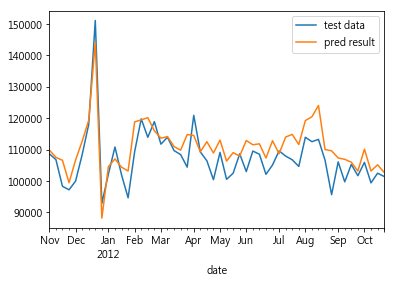

In [39]:
ax = test_1.plot(y = 'weeklySales', x = 'date', label = 'test data')
test_1.plot(y = 'Pred_Sales', x = 'date', label = 'pred result',ax=ax)

# Question 2 [Random Forest]
* Q2.1 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4})$. 
* Q2.2 (15%) $y_t = f(y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-52})$. 

In [8]:
from sklearn.ensemble import RandomForestRegressor

Create columns of $y_{t-1}, y_{t-2}, y_{t-3}, y_{t-4}, y_{t-52}$

In [9]:
full_data = pd.concat([dep2train,dep2test]).reset_index(drop=True)
full_data['t-1'] = full_data['weeklySales'].shift(periods= 1)
full_data['t-2'] = full_data['weeklySales'].shift(periods= 2)
full_data['t-3'] = full_data['weeklySales'].shift(periods= 3)
full_data['t-4'] = full_data['weeklySales'].shift(periods= 4)
full_data['t-52'] = full_data['weeklySales'].shift(periods= 52)

## Method 2-1

In [10]:
train_2_1 = full_data.loc[full_data.fold == 'train', :].iloc[:,:-1]
train_2_1_x = train_2_1.iloc[:,-4:]
train_2_1_y = train_2_1.iloc[:,1]

In [11]:
q2_1 = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
q2_1.fit(train_2_1_x.dropna(),train_2_1_y.iloc[4:,])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [12]:
test_2_1 = full_data.loc[full_data.fold == 'test', :].iloc[:,:-1]
test_2_1['RF1_Pred'] = q2_1.predict(test_2_1.iloc[:,-4:])

In [13]:
print("MAPE of method 2-1 is {:.2f}".format(MAPE(test_2_1.weeklySales, test_2_1.RF1_Pred)))

MAPE of method 2-1 is 5.94


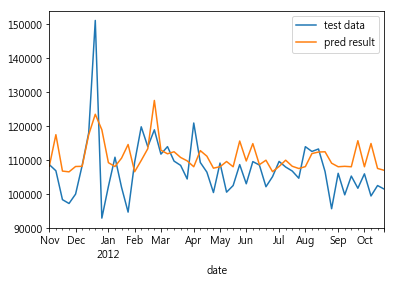

In [14]:
ax = test_2_1.plot(y = 'weeklySales', x = 'date', label = 'test data')
test_2_1.plot(y = 'RF1_Pred', x = 'date', label = 'pred result',ax=ax)

## Method 2-2

In [15]:
train_2_2 = full_data.loc[full_data.fold == 'train', :]
test_2_2 = full_data.loc[full_data.fold == 'test', :]

train_2_2_x = train_2_2.iloc[:,-5:].dropna()
train_2_2_y = train_2_2.iloc[52:,1]

In [16]:
q2_2 = RandomForestRegressor(max_depth=2, random_state=0,
                             n_estimators=100)
q2_2.fit(train_2_2_x,train_2_2_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [17]:
test_2_2['RF2_Pred'] = q2_2.predict(test_2_2.iloc[:,-5:])

/Users/ryanhuang/.conda/envs/untitled/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
print("MAPE of method 2-2 is {:.2f}".format(MAPE(test_2_2.weeklySales, test_2_2.RF2_Pred)))

MAPE of method 2-2 is 3.82


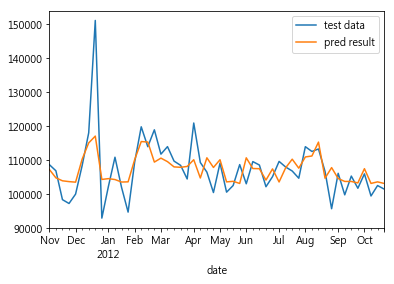

In [19]:
ax = test_2_2.plot(y = 'weeklySales', x = 'date', label = 'test data')
test_2_2.plot(y = 'RF2_Pred', x = 'date', label = 'pred result',ax=ax)

# Question 3 [Gaussian Process Regression]

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, WhiteKernel

### Change the Kernel here

In [21]:
q3_full = pd.concat([dep2train,dep2test],ignore_index=True).iloc[:,[1,2]]
q3_full = q3_full.reset_index()
q3_train = q3_full.loc[q3_full.fold == 'train',:]
q3_test = q3_full.loc[q3_full.fold == 'test',:]
q3_test = q3_test.reset_index()

### Q3-1 Normalize the weekly sales using training data

In [55]:
k1 = 1 * RBF(length_scale=5, length_scale_bounds=(1,50))
k2 = 1 * ExpSineSquared(length_scale=1,periodicity=55,periodicity_bounds=(50, 100))
k3 = 1 * WhiteKernel(noise_level_bounds=(1e-05, 10))

In [56]:
kernel = k1 + k2 + k3
gp_3_1 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
gp_3_1.fit(q3_train.index.values.reshape(-1,1), q3_train.weeklySales.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=5) + 1**2 * ExpSineSquared(length_scale=1, periodicity=55) + 1**2 * WhiteKernel(noise_level=1),
             n_restarts_optimizer=9, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [57]:
q3_test['pred_3_1'] = gp_3_1.predict(q3_test.loc[:,'index'].values.reshape(-1,1))

In [58]:
print("MAPE of method 3-1 is {:.2f}".format(MAPE(y_true=q3_test.weeklySales, y_pred=q3_test.pred_3_1)))

MAPE of method 3-1 is 6.66


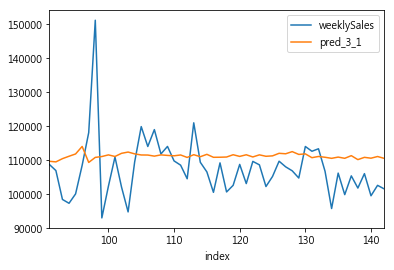

In [59]:
ax = q3_test.plot(x='index', y='weeklySales')
q3_test.plot(x='index', y='pred_3_1', ax=ax)

In [60]:
gp_3_1.kernel_

316**2 * RBF(length_scale=2.34) + 316**2 * ExpSineSquared(length_scale=1.08e-05, periodicity=50) + 316**2 * WhiteKernel(noise_level=10)

### Q3-2 Don't normalize

In [28]:
k1 = 1 * RBF(length_scale=5, length_scale_bounds=(1,50))
k2 = 1 * RBF() * ExpSineSquared(length_scale=1,periodicity=50,periodicity_bounds=(50, 100))
k3 = 1 * WhiteKernel(noise_level_bounds=(1e-05, 10))

In [29]:
kernel2 = k1 + k2 + k3
gp_3_2 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
gp_3_2.fit(q3_train.index.values.reshape(-1,1), q3_train.weeklySales.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=5) + 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=50) + 1**2 * WhiteKernel(noise_level=1),
             n_restarts_optimizer=9, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [30]:
q3_test['pred_3_2'] = gp_3_2.predict(q3_test.loc[:,'index'].values.reshape(-1,1))

In [31]:
print("MAPE of method 3-2 is {:.2f}".format(MAPE(q3_test.weeklySales, q3_test.pred_3_2)))

MAPE of method 3-2 is 22.30


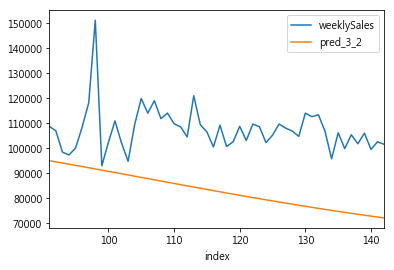

In [32]:
ax = q3_test.plot(x='index', y='weeklySales')
q3_test.plot(x='index', y='pred_3_2', ax=ax)

In [33]:
gp_3_2.kernel_

316**2 * RBF(length_scale=50) + 316**2 * RBF(length_scale=1e+05) * ExpSineSquared(length_scale=1e+05, periodicity=100) + 316**2 * WhiteKernel(noise_level=10)

### Q3-3 Use Normalized model to perform "Expanding Window" prediction

In [34]:
gp_3_3 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=True)
gp_3_3.fit(q3_train.index.values.reshape(-1,1), q3_train.weeklySales.values.reshape(-1,1))

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=5) + 1**2 * RBF(length_scale=1) * ExpSineSquared(length_scale=1, periodicity=50) + 1**2 * WhiteKernel(noise_level=1),
             n_restarts_optimizer=9, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [35]:
pred = []
for i in range(91,143):
    gp_3_3_p = GaussianProcessRegressor(kernel=gp_3_3.kernel_, optimizer=None, normalize_y=True)
    gp_3_3_p.fit(q3_full.iloc[:i,:].loc[:,'index'].values.reshape(-1,1), 
                 q3_full.iloc[:i,:].loc[:,'weeklySales'].values.reshape(-1,1))
    pred.append(gp_3_3_p.predict(q3_full.iloc[i,:]['index'].reshape(-1,1))[0][0])
q3_test['pred_3_3'] = pred

In [36]:
print("MAPE of method 3-3 is {:.2f}".format(MAPE(q3_test.weeklySales, q3_test.pred_3_3)))

MAPE of method 3-3 is 6.02


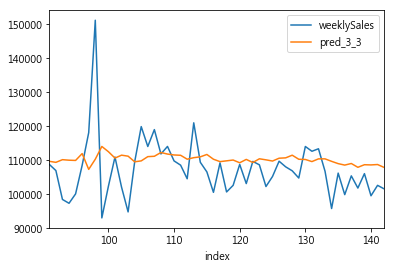

In [37]:
ax = q3_test.plot(x='index', y='weeklySales')
q3_test.plot(x='index', y='pred_3_3', ax=ax)